In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import datetime

# Jupyter Notebook esetén az inline diagramokhoz:
%matplotlib inline



In [2]:
# Időintervallum beállítása: az elmúlt 5 év
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.datetime.today() - datetime.timedelta(days=5*365)).strftime('%Y-%m-%d')

ticker = 'nvda'
df = yf.download(ticker, start=start_date, end=end_date)
print("Letöltött adatok:")
print(df.tail())  # az utolsó néhány sor megtekintése


[*********************100%***********************]  1 of 1 completed

Letöltött adatok:
Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2025-01-28  128.990005  129.000000  116.250000  121.809998  579666400
2025-01-29  123.699997  126.889999  120.050003  126.500000  467120600
2025-01-30  124.650002  125.000000  118.099998  123.099998  392925500
2025-01-31  120.070000  127.849998  119.190002  123.779999  390372900
2025-02-03  116.660004  118.570000  113.010002  114.750000  369021900


In [3]:
# Csak a záróárakat használjuk
data = df[['Close']].copy()

# Normalizálás 0 és 1 közé
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Sliding window mérete: hány nap adataiból jósolunk
window_size = 30

def create_dataset(dataset, window_size):
    X, y = [], []
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i+window_size])
        y.append(dataset[i+window_size])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data, window_size)

# Az adatok 80%-át használjuk tanuláshoz
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



X_train shape: (980, 30, 1)
X_test shape: (245, 30, 1)


In [4]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Modell betanítása
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6014e-04 - val_loss: 0.0064
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0197e-04 - val_loss: 0.0050
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0114e-04 - val_loss: 0.0069
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1915e-04 - val_loss: 0.0071
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6036e-04 - val_loss: 0.0086
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5765e-04 - val_loss: 0.0165
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8838e-04 - val_loss: 0.0086
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7405e-04 - val_loss: 0.0129
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7211e-04 - val_loss: 0.0061
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6078e-04 - val_loss: 0.0077
Epoch 12/50
31/31 ━━━━━

In [5]:
# Utolsó 30 napos ablak az ismert adatokból
last_window = scaled_data[-window_size:]
forecast_input = np.array(last_window)
forecast_input = forecast_input.reshape(1, window_size, 1)

forecast = []

# 30 napos előrejelzés
n_future = 30
for _ in range(n_future):
    pred = model.predict(forecast_input)
    forecast.append(pred[0,0])
    
    # Az új értéket hozzáfűzzük a windowhoz, majd eltávolítjuk a legrégebbit
    forecast_input = np.append(forecast_input[:,1:,:], [[pred[0]]], axis=1)

# Visszakonvertálás az eredeti skálára
forecast_actual = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Készítünk egy időindexet az előrejelzéshez
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_future)
forecast_df = pd.DataFrame(forecast_actual, index=future_dates, columns=['Forecast'])

print("Előrejelzett árak a következő 30 napra:")
print(forecast_df.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

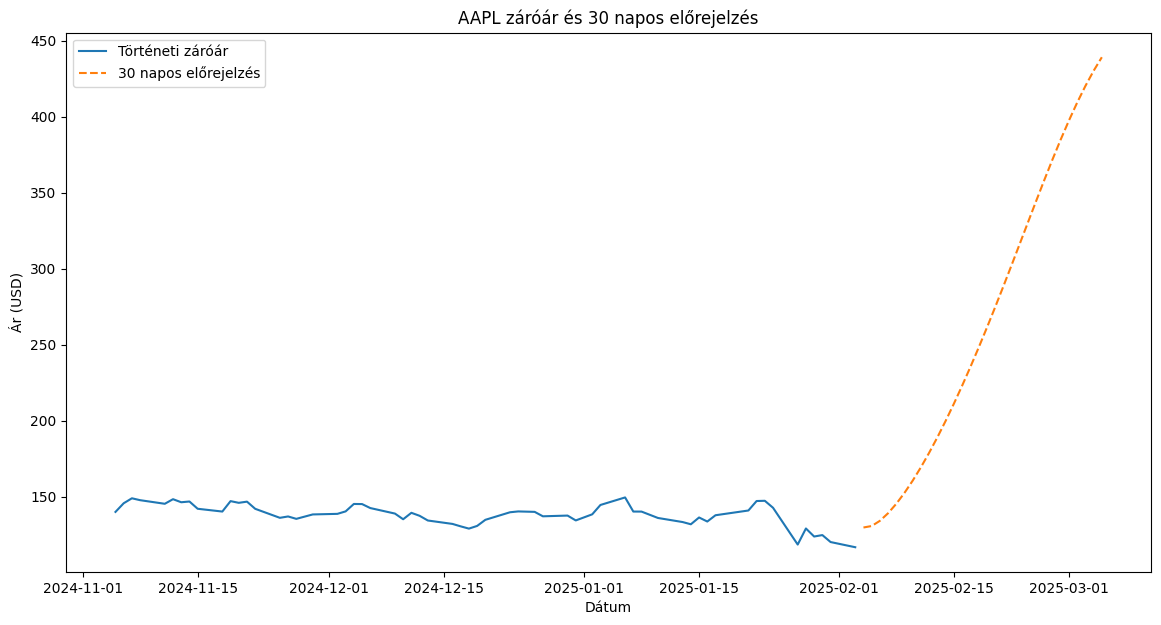

In [6]:
# Történeti záróárak (utolsó 60 nap, hogy látható legyen a trend)
historical_plot = data[-60:]

plt.figure(figsize=(14,7))
plt.plot(historical_plot.index, historical_plot['Close'], label='Történeti záróár')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='30 napos előrejelzés', linestyle='--')
plt.title('AAPL záróár és 30 napos előrejelzés')
plt.xlabel('Dátum')
plt.ylabel('Ár (USD)')
plt.legend()
plt.style.use("dark_background")
plt.show()

